# Mounting a Successful Attack Against ASCADv2

This notebook shows how to use the pretrained `ascadv2_singlemlp_231M.pt` model to perform a successful attack against the ASCADv2 dataset. The attack is based on the paper "Scoop: An Optimization Algorithm for Profiling Attacks against Higher-Order Masking". You can train your own model by following the instructions in the `ascadv2_profiling.ipynb` notebook.

It requires you to download the ASCADv2 ecxtracted dataset from the [ANSSI website](https://www.data.gouv.fr/fr/datasets/ascadv2/) and to place it in the correct folder (see the second python cell). It requires you to have a GPU to run the attack, and also to have at least 32GB free of RAM. The conclusion of this notebook is the Guessing Entropy which is the expected position of the correct key in the vector of the likelihood of the key. This is a reproduction of Figure 6.3.1 (right) of the paper.

### Dependencies

If you haven't installed the required dependencies, you should consider activating the `scoop_ches25` environment that contains all you need to run this notebook.

```bash
conda activate scoop_ches25
```

In [1]:
import sys
sys.path.insert(0, 'src/')
from utils import construct_labels, sbox
from metrics import guessing_entropy
import h5py
import torch
import matplotlib.pyplot as plt
import numpy as np

print('__Python VERSION:', sys.version)
print('__pyTorch VERSION:', torch.__version__)
print('__CUDNN VERSION:', torch.backends.cudnn.version())
print('__Number CUDA Devices:', torch.cuda.device_count())
print('__Devices')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Active CUDA Device:", device)

__Python VERSION: 3.11.10 (main, Oct  3 2024, 07:29:13) [GCC 11.2.0]
__pyTorch VERSION: 2.5.1
__CUDNN VERSION: 90100
__Number CUDA Devices: 1
__Devices
Active CUDA Device: cuda


# Loading the Dataset

Here you can put custom path to the ASCADv2 dataset. The cell below outputs a figure so that you can verify the dataset is correctly loaded.

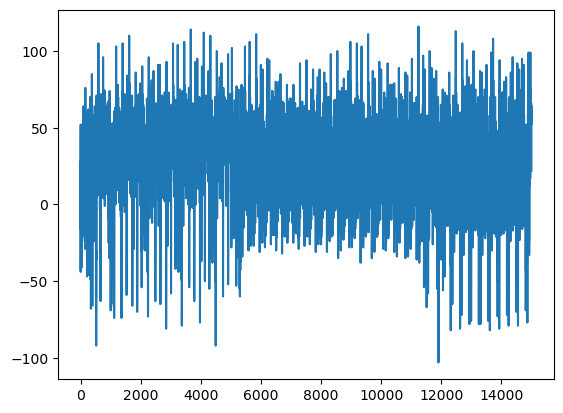

In [2]:
path = 'dataset/ASCAD_data/ASCAD_databases/ascadv2-extracted.h5'

ascad_db = h5py.File(path, 'r')
profiling_traces = ascad_db['Profiling_traces']
attack_traces = ascad_db['Attack_traces']

X_test = attack_traces['traces']
metadata_test = attack_traces['metadata']
pt_test = metadata_test['plaintext']
key_test = metadata_test['key']
Y_test = attack_traces['labels']

plt.figure()
plt.plot(profiling_traces['traces'][0])
plt.show()

In [3]:
metadata_profiling = profiling_traces['metadata']
inds = metadata_profiling['key']

## Generating the Labels

The cell below generates the non-worst-case labels for ASCADv2 as per Appendix F.1.

In [4]:
byte = 4

labels, pts, keys = construct_labels(byte, profiling_traces)
labels_attack, pts_attack, keys_attack = construct_labels(byte, attack_traces)

Constructing labels: 100%|██████████| 10000/10000 [00:00<00:00, 2817048.83it/s]


## Splitting the Dataset

See section 6.3.1 of the paper for more details.

In [5]:
train_len = 200000
test_len = 300000
val_len = 1000
X = torch.Tensor(np.array(profiling_traces['traces'][:train_len]))
Y = torch.LongTensor(labels[:train_len])

X_val = torch.Tensor(np.array(attack_traces['traces']))
Y_val = torch.LongTensor(labels_attack)
X_attack = torch.Tensor(np.array(profiling_traces['traces'][train_len:train_len+test_len]))
Y_attack = torch.LongTensor(labels[train_len:train_len+test_len])


## Loading the Model

If you have incorectly selected your GPU, this cell will crash.

In [ ]:
metadata_profiling = profiling_traces['metadata']
pts_attack = metadata_profiling['plaintext']
keys_attack = metadata_profiling['key']
val_len = train_len

best_model = torch.load('ascadv2_singlemlp_231M.pt').to(device)
n_params = sum(p.numel() for p in best_model.parameters())
print('Number of parameters:', n_params)    

pts = np.array([pts_attack[i][byte] for i in range(len(pts_attack))]).astype(int)
pts = pts[val_len:val_len+test_len]
print(len(pts))

keys_attack = np.array([keys_attack[i][byte] for i in range(len(keys_attack))]).astype(int)
keys_attack = keys_attack[val_len:val_len+test_len]
new_pts = np.array([pts[i]^keys_attack[i] for i in range(len(pts))]).astype(int)
true_key = int(0)

/tmp/ipykernel_77792/1874842739.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model = torch.load('ascadv2_singlemlp_231M.pt').to(device)


Number of parameters: 231464205
300000


## Guessing Entropy Computation

This cell will take a long time to run. You can change the parameters of the GE function:

step=10000: the number of traces between each GE computation

n_tries=20: the number of times the GE is computed (the average is returned)

If you have a small GPU, `batch_pred` can be set to `True` to reduce the GPU memory usage.

In [7]:
GE_scoop, n_attacks =  guessing_entropy(best_model, X_attack, new_pts, sbox, device, true_key, n_bits=8, n_tries=20, n_attack=300000, verbose=True, step=10000, batch_pred=True)

100%|██████████| 30/30 [45:13<00:00, 90.46s/it] 


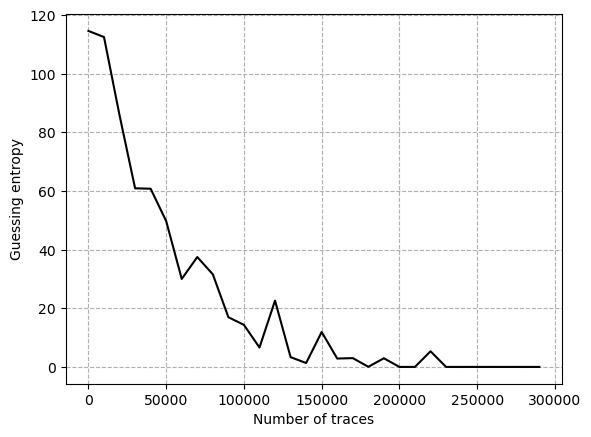

In [8]:
fig, ax = plt.subplots()
ax.plot(n_attacks, GE_scoop, color='k')
ax.set_xlabel('Number of traces')
ax.set_ylabel('Guessing entropy')
ax.grid(linestyle='--')
plt.show()
